In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd


## Download Individual Buildings Timeseries

Get the timeseries data and saves to a specified folder.

In [223]:
tcad = pd.read_parquet('data/processed/3.1-tcad_resstock.parquet')

timeseries_url = "https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_amy2018_release_1.1/timeseries_individual_buildings/by_state/upgrade=0/state=TX"
# timeseries_url = "https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/timeseries_individual_buildings/by_state/upgrade=0/state=TX"
timeseries_urls = set([f'{timeseries_url}/{id}-0.parquet' for id in tcad['selected_resstock_id']])

In [224]:
import nest_asyncio
nest_asyncio.apply()
import aiohttp, aiofiles
import asyncio
from pathlib import Path

folder = 'data/external/resstock_individual_timeseries/'
if not Path(folder).exists():
    Path(folder).mkdir(parents=True,exist_ok=True)
async def read_parquet2(session,url):
    for _ in range(3):
        try:
            async with session.get(url) as resp:
                # resp.raise_for_status() # Need to test this
                if resp.status == 200:
                    filepath = f'{folder}{url.split('/')[-1]}'
                    async with aiofiles.open(filepath,'wb') as f:
                        await f.write(await resp.read())
                    break
        except aiohttp.ClientError:
            await asyncio.sleep(1)

        
async def download(urls):
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector) as session: 
        tasks = [read_parquet2(session,url) for url in urls]
        await asyncio.gather(*tasks)

await download(timeseries_urls)
    

## Load TCAD with ResStock Matches

In [3]:
import pandas as pd
tcad = pd.read_parquet('data/processed/3.1-tcad_resstock.parquet')
tcad_78733 = tcad[tcad['situs_zip']=='78733']
tcad_78741 = tcad[tcad['situs_zip']=='78741']

In [4]:
cleaned_78733 = tcad_78733[tcad_78733['geometry_floor_area']!='4000+'].copy()

In [5]:
import os 

folder = 'data/external/resstock_individual_timeseries_amy18'
filepaths = [f'{folder}/{file}' for file in os.listdir(folder)]

In [6]:
import pandas as pd

# Load timeseries for all restock buildings and pivot
resstock_all_bldgs = pd.concat([pd.read_parquet(path,columns=['timestamp','out.electricity.total.energy_consumption']) for path in filepaths])
pivoted_df = resstock_all_bldgs.reset_index().pivot(columns='bldg_id',values='out.electricity.total.energy_consumption',index='timestamp')
pivoted_df

bldg_id,384,2001,3919,3987,6869,6887,7894,8633,9576,10049,...,539445,540899,541516,542280,543679,545529,547233,547367,548201,548661
timestamp,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:15:00,1.963,0.106,3.207,2.607,0.173,0.163,0.167,0.171,0.225,0.024,...,0.167,0.379,0.088,1.116,0.092,0.912,0.034,0.036,0.188,0.138
2007-01-01 00:30:00,2.340,0.531,3.158,2.601,0.173,0.163,0.167,0.171,0.225,0.024,...,0.172,0.380,0.088,1.124,0.092,0.945,0.034,0.036,0.188,0.138
2007-01-01 00:45:00,1.942,0.101,3.099,2.604,0.146,0.163,0.141,0.171,0.286,0.024,...,0.176,0.253,0.126,1.124,0.092,0.974,0.034,0.036,0.189,0.138
2007-01-01 01:00:00,1.943,0.101,3.075,2.617,0.146,0.173,0.141,0.161,0.305,0.024,...,0.180,0.253,0.126,1.525,0.092,0.998,0.034,0.036,0.189,0.138
2007-01-01 01:15:00,0.178,0.069,0.311,1.039,0.107,0.146,0.092,0.123,0.189,0.011,...,0.027,0.209,0.083,0.107,0.062,0.135,0.021,0.010,0.159,0.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31 23:00:00,1.877,0.133,0.581,2.291,0.251,0.220,0.263,0.277,0.348,0.025,...,0.137,0.651,0.093,1.063,0.247,0.811,0.037,0.037,0.256,0.167
2007-12-31 23:15:00,1.993,0.123,3.809,2.604,0.225,0.201,0.245,0.234,0.295,0.025,...,0.143,0.582,0.090,1.072,0.219,0.837,0.036,0.029,0.217,0.140
2007-12-31 23:30:00,2.028,0.123,2.557,2.636,0.225,0.202,0.225,0.234,0.295,0.025,...,0.150,0.583,0.090,1.093,0.219,0.884,0.036,0.029,0.218,0.140


## 78741

In [192]:
# How many times each resstock building appears in 78741.
# tcad_78741['selected_resstock_id'].value_counts()


"-1325","Total 78741_E-RES_SINGLE FAMILY (2,674) meters",3372571.75

"-1268","Total 78733_E-RES_SINGLE FAMILY (3,014) meters",8510036



In [7]:
def replace_year(dt_series,year=1904):
    return dt_series.apply(lambda x:pd.Timestamp(year=year,month=x.month,day=x.day,hour=x.hour,minute=x.minute))

def load_utenergy(spid,zipcode,remove_poor_matches=False):
    df = pd.read_csv(f'data/external/utenergy/UT_sID_-{spid}_dates_2017.01.01_through_2021.10.01.csv')
    columns = [*df.columns,'None']
    df = df.reset_index()
    df.columns = columns
    df = df.drop(columns='None')
    df['DateTime'] = pd.to_datetime(df[f'-{spid} kWh DateTime'])
    df['Year'] = df['DateTime'].dt.year
    df['DateTime'] = replace_year(df['DateTime'])
    df = df.rename(columns={f'-{spid} kWh Value':'kWh Value'})[['DateTime','kWh Value','Year']].pivot(index='DateTime',values='kWh Value',columns='Year')

    # Year is 2007 on original resstock file
    tcad_zipcode = tcad[tcad['situs_zip']==str(zipcode)]
    if remove_poor_matches:
        tcad_zipcode = tcad_zipcode[tcad_zipcode['geometry_floor_area']!='4000+'].copy()
    resstock_aggregate = sum([count*pivoted_df[id] for id,count in tcad_zipcode['selected_resstock_id'].value_counts().to_dict().items()]).iloc[:-1].reset_index()
    resstock_aggregate['timestamp'] = replace_year(resstock_aggregate['timestamp'])
    resstock_aggregate = resstock_aggregate.set_index('timestamp')[0]
    df['resstock'] = resstock_aggregate
    # resstock_aggregate.plot()
    return df

high_income_df = load_utenergy(1268,78733)

In [8]:
tcad_78733.query("geometry_floor_area=='4000+'")

,prop_id,imprv_id,prop_val_yr_x,situs_num,situs_street_prefx,situs_street,situs_street_suffix,situs_unit,situs_city,situs_zip,...,imprv_homesite_pct,en_exempt,pc_exempt,so_exempt,eco_exempt,vintage,geometry_floor_area,geometry_foundation_type,roof_material,selected_resstock_id
136,115615,5239087,2023,3114,NaN,BARTON POINT,DR,NaN,AUSTIN,78733,...,100.0,F,F,F,F,1990s,4000+,Slab,Composition Shingles,128937
394,120228,5243120,2023,2401,NaN,DOMINION,HL,NaN,NaN,78733,...,100.0,F,F,F,F,2010s,4000+,None,None,191558
395,120229,5243122,2023,2419,NaN,DOMINION,HL,NaN,NaN,78733,...,100.0,F,F,F,F,2010s,4000+,None,None,524302
396,120230,5243123,2023,2601,NaN,DOMINION,HL,NaN,NaN,78733,...,100.0,F,F,F,F,2000s,4000+,Slab,"Tile, all",304275
398,120232,5243125,2023,2608,NaN,DOMINION,HL,NaN,NaN,78733,...,100.0,F,F,F,F,1990s,4000+,Slab,"Tile, all",533484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,773910,5561922,2023,612,NaN,BRANDON,WAY,NaN,AUSTIN,78733,...,100.0,F,F,F,F,2000s,4000+,Slab,"Tile, all",63649
5477,818429,5575885,2023,8504,NaN,GALEANA TRACE,CV,NaN,NaN,78733,...,100.0,F,F,F,F,2010s,4000+,Slab,Composition Shingles,269239
5582,834336,5583100,2023,1205,N,WESTON,LN,NaN,AUSTIN,78733,...,100.0,F,F,F,F,1980s,4000+,Slab,None,360930
6376,959087,5786241,2023,NaN,NaN,CAMELBACK,DR,NaN,NaN,78733,...,100.0,F,F,F,F,2010s,4000+,None,None,423337


In [9]:
clean_high_income_df = load_utenergy(1268,78733,remove_poor_matches=True)

In [10]:
clean_high_income_df

Year,2017,2018,2019,2020,2021,resstock
DateTime,,,,,,
1904-01-01 00:00:00,NaN,4555.337891,2113.836914,2297.746826,3501.007812,NaN
1904-01-01 00:15:00,NaN,4657.682617,2218.614502,2349.735352,3608.817627,2612.834
1904-01-01 00:30:00,NaN,4585.977051,2249.573242,2386.318115,3611.121582,2576.947
1904-01-01 00:45:00,NaN,4634.956055,2273.536621,2412.498535,3654.754639,2560.438
1904-01-01 01:00:00,NaN,4650.370117,2248.848145,2379.550293,3598.289062,2486.731
...,...,...,...,...,...,...
1904-12-31 22:45:00,4094.447754,1772.045288,1911.049194,3254.665771,NaN,2914.221
1904-12-31 23:00:00,4174.355469,1813.762939,1958.649658,3224.585938,NaN,2883.492
1904-12-31 23:15:00,4243.541992,1858.992432,2069.900146,3315.022461,NaN,2627.151


In [11]:
clean_high_income_df

Year,2017,2018,2019,2020,2021,resstock
DateTime,,,,,,
1904-01-01 00:00:00,NaN,4555.337891,2113.836914,2297.746826,3501.007812,NaN
1904-01-01 00:15:00,NaN,4657.682617,2218.614502,2349.735352,3608.817627,2612.834
1904-01-01 00:30:00,NaN,4585.977051,2249.573242,2386.318115,3611.121582,2576.947
1904-01-01 00:45:00,NaN,4634.956055,2273.536621,2412.498535,3654.754639,2560.438
1904-01-01 01:00:00,NaN,4650.370117,2248.848145,2379.550293,3598.289062,2486.731
...,...,...,...,...,...,...
1904-12-31 22:45:00,4094.447754,1772.045288,1911.049194,3254.665771,NaN,2914.221
1904-12-31 23:00:00,4174.355469,1813.762939,1958.649658,3224.585938,NaN,2883.492
1904-12-31 23:15:00,4243.541992,1858.992432,2069.900146,3315.022461,NaN,2627.151


In [12]:
len(tcad_78733)

3035


"-1268","Total 78733_E-RES_SINGLE FAMILY (3,014) meters",8510036

TCAD has 21 more buildings than meters (3035 vs 3014).

OSM-TCAD matches: 2761 (not used for limiting here)


NameError: name 'plt' is not defined

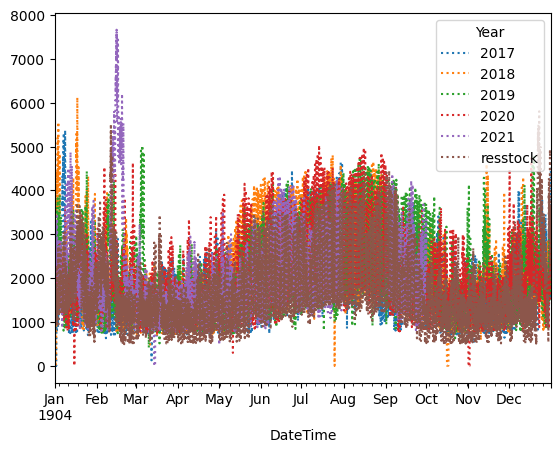

In [13]:
high_income_df.plot(linestyle=':')
plt.plot(clean_high_income_df.index,clean_high_income_df['resstock'],label='dsaf')

high_income_df.resample('D').sum().plot(style=[':',':',':',':',':','-'])
plt.plot(clean_high_income_df.resample('D').sum().index,clean_high_income_df['resstock'].resample('D').sum(),'--',label='resstock_clean')
plt.legend()

high_income_df.resample('M').sum().plot(style=[':',':',':',':',':','-'])

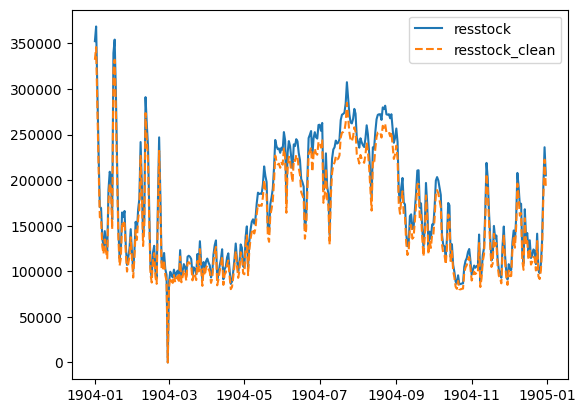

In [ ]:

plt.figure()
plt.plot(high_income_df.resample('D').sum().index,high_income_df['resstock'].resample('D').sum(),label='resstock')
plt.plot(clean_high_income_df.resample('D').sum().index,clean_high_income_df['resstock'].resample('D').sum(),'--',label='resstock_clean')
plt.legend()


In [ ]:
low_income_df = load_utenergy(1325,78741)

"-1325","Total 78741_E-RES_SINGLE FAMILY (2,674) meters",3372571.75

TCAD has 710 more buildings than Austin Energy meters (3384-2674).

OSM-TCAD matches: 2331 (not used for filtering here)

<Axes: xlabel='DateTime'>

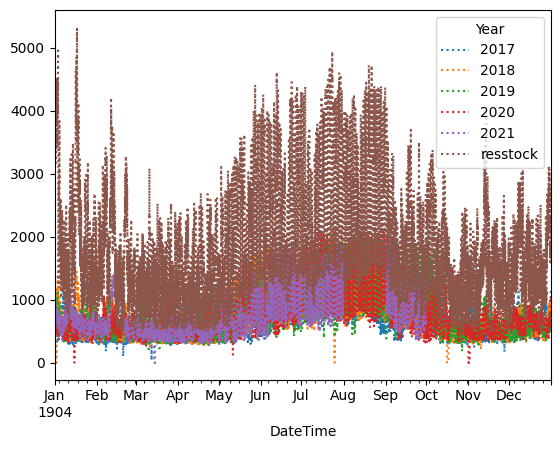

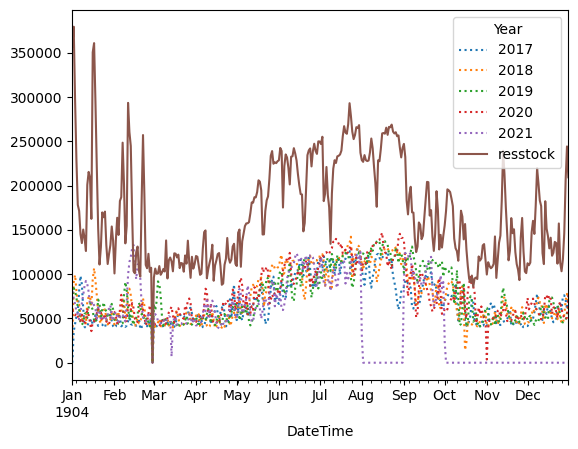

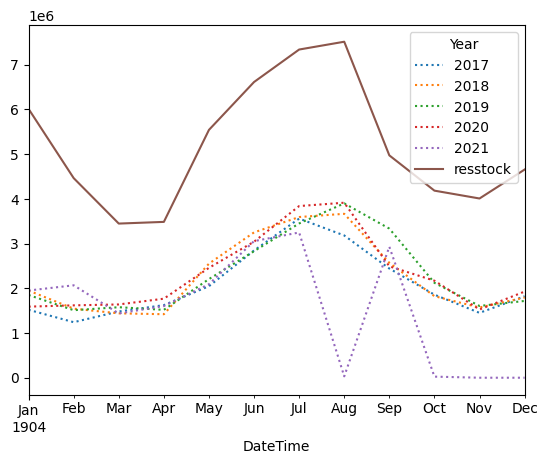

In [202]:
low_income_df.plot(linestyle=':')
low_income_df.resample('D').sum().plot(style=[':',':',':',':',':','-'])
low_income_df.resample('M').sum().plot(style=[':',':',':',':',':','-'])

In [203]:
combined_df = pd.concat([low_income_df[[2017,2018,2019,2020]].mean(axis=1),low_income_df['resstock']],axis=1).rename(columns={0:'78741_AE','resstock':'78741_resstock'})
combined_df[['78733_AE','78733_resstock']]= pd.concat([high_income_df[[2017,2018,2019,2020]].mean(axis=1),high_income_df['resstock']],axis=1).rename(columns={0:'78733_AE','resstock':'78733_resstock'})

<Axes: xlabel='DateTime'>

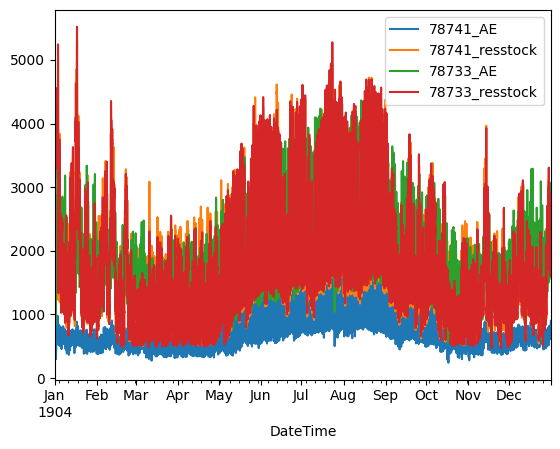

In [204]:
combined_df.plot()

<Axes: xlabel='DateTime'>

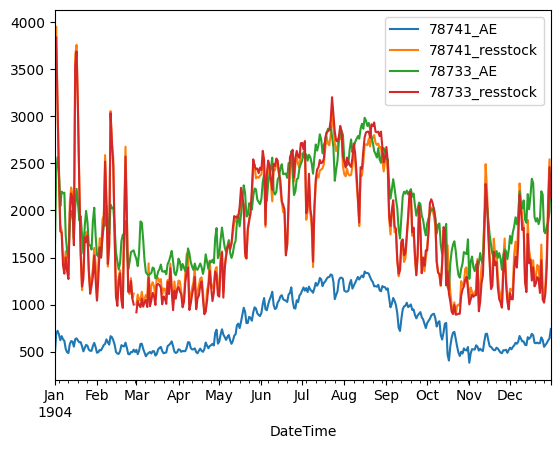

In [205]:
combined_df.resample('D').mean().plot()

<Axes: xlabel='DateTime'>

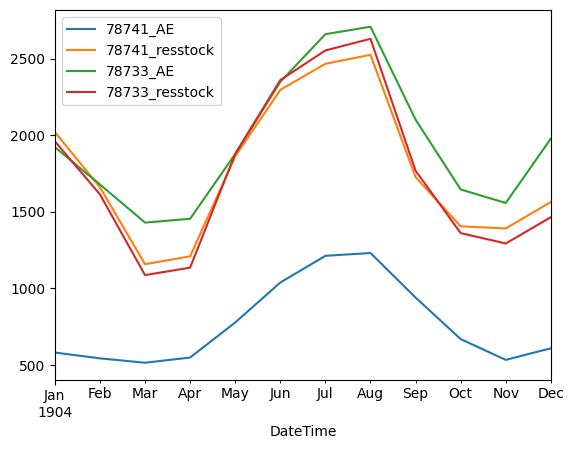

In [206]:
combined_df.resample('M').mean().plot()

In [207]:
len(tcad_78741[tcad_78741['yr_built']>2020])

117

In [208]:
len(tcad_78733[tcad_78733['yr_built']>2020])

50

<BarContainer object of 9 artists>

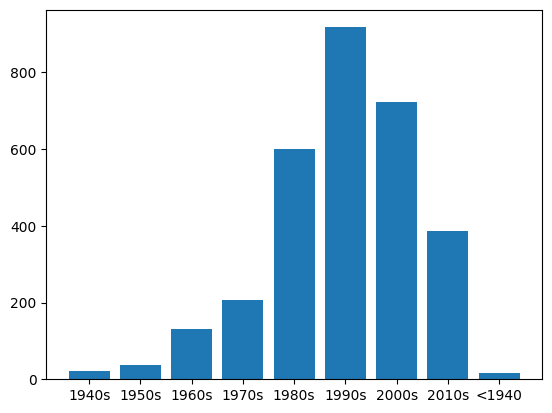

In [222]:
data = tcad_78733.vintage.value_counts().sort_index()
plt.figure()
plt.bar(data.index,data.values)



In [219]:
data

vintage
2010s    1087
1960s     574
2000s     519
1970s     398
1950s     266
1980s     210
1940s     193
1990s     101
<1940      36
Name: count, dtype: int64

<BarContainer object of 9 artists>

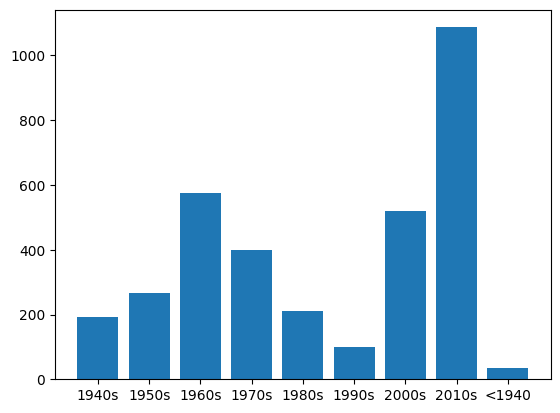

In [221]:
data = tcad_78741.vintage.value_counts().sort_index()
plt.figure()
plt.bar(data.index,data.values)

In [210]:
import matplotlib.pyplot as plt

In [225]:
restock_freq_33

selected_resstock_id
264295    131
455131    124
161312    116
480462    108
287655     78
         ... 
330952      1
534196      1
22607       1
75896       1
279594      1
Name: count, Length: 480, dtype: int64

In [212]:
list(restock_freq_33.index)

[264295,
 455131,
 161312,
 480462,
 287655,
 31139,
 244834,
 73700,
 88914,
 494881,
 488097,
 26782,
 159564,
 231873,
 548201,
 101707,
 424001,
 76951,
 384,
 354596,
 411904,
 280119,
 373106,
 74195,
 18128,
 462491,
 275769,
 171320,
 154004,
 380641,
 481785,
 183468,
 250935,
 547233,
 78491,
 448026,
 359647,
 175194,
 325912,
 301739,
 43845,
 65140,
 192592,
 360930,
 214563,
 84148,
 482572,
 208103,
 413056,
 315133,
 396451,
 208052,
 68144,
 21353,
 482375,
 212495,
 80485,
 253740,
 423337,
 381952,
 444582,
 300224,
 308346,
 329199,
 304520,
 90720,
 369818,
 74861,
 450262,
 335505,
 257398,
 389322,
 61835,
 135725,
 90467,
 26358,
 253617,
 373974,
 536935,
 80024,
 346684,
 190645,
 180521,
 508066,
 247177,
 206140,
 191166,
 401989,
 308339,
 202646,
 524302,
 269221,
 40541,
 355906,
 329326,
 63568,
 127267,
 63649,
 207786,
 124308,
 493850,
 388622,
 32434,
 145259,
 289049,
 199448,
 357353,
 298404,
 294259,
 368143,
 293920,
 9576,
 345794,
 296103,
 19

In [213]:
type(list(restock_freq_33.index)[0])

int

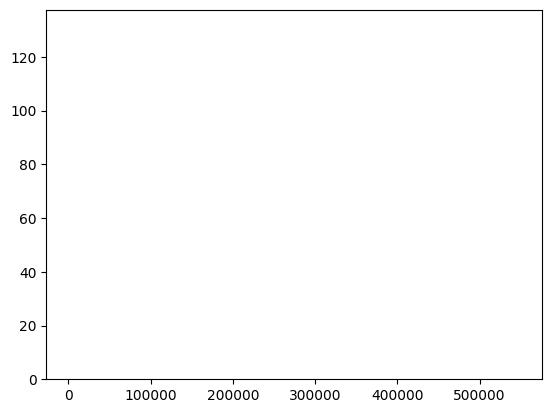

In [214]:
restock_freq_33 = tcad_78733['selected_resstock_id'].value_counts()
plt.figure()
plt.bar(list(restock_freq_33.index),list(restock_freq_33.values))
plt.show()

In [240]:
tcad_78733['selected_resstock_id'].value_counts().sort_values(ascending=False).to_frame()

,count
selected_resstock_id,
264295,131
455131,124
161312,116
480462,108
287655,78
...,...
166626,1
429242,1
419933,1


In [239]:
tcad_78733['selected_resstock_id'].value_counts(normalize=True).sort_values(ascending=False).cumsum().to_frame()

,proportion
selected_resstock_id,
264295,0.043163
455131,0.084020
161312,0.122241
480462,0.157825
287655,0.183526
...,...
166626,0.998682
429242,0.999012
419933,0.999341


In [101]:
tcad_78741['selected_resstock_id'].value_counts(normalize=True).sort_values(ascending=False).to_dict()

{246005: 0.09722222222222222,
 473596: 0.07919621749408984,
 100906: 0.05466903073286052,
 159564: 0.04521276595744681,
 388622: 0.02541371158392435,
 319205: 0.02186761229314421,
 514884: 0.020685579196217493,
 135951: 0.015957446808510637,
 130192: 0.014184397163120567,
 539445: 0.012706855791962174,
 135109: 0.012411347517730497,
 545529: 0.011229314420803783,
 503941: 0.010933806146572104,
 64465: 0.010933806146572104,
 8633: 0.010638297872340425,
 398046: 0.010638297872340425,
 416658: 0.010342789598108746,
 399858: 0.00975177304964539,
 355906: 0.008865248226950355,
 83127: 0.008569739952718676,
 478503: 0.008274231678486997,
 481750: 0.0076832151300236405,
 345794: 0.007387706855791962,
 80707: 0.0070921985815602835,
 124328: 0.0070921985815602835,
 444582: 0.0070921985815602835,
 434246: 0.0067966903073286055,
 295206: 0.0067966903073286055,
 299583: 0.0065011820330969266,
 494682: 0.0062056737588652485,
 200834: 0.0062056737588652485,
 117712: 0.005319148936170213,
 389322: 0.